## Trail to redact a given Aadhaar card image

In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

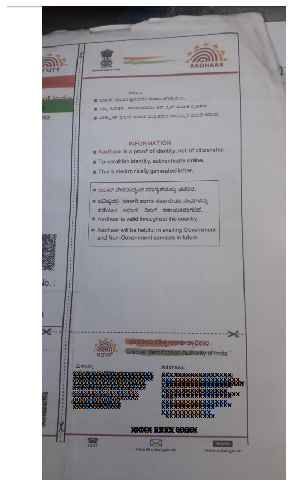

In [2]:
def display_image(image, size=(5,15), axis=False):
    plt.figure(figsize=size)
    plt.axis('off')
    if axis:
        plt.axis('on')    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap='gray')
img = cv2.imread('img_redacted.png')
display_image(img)

### Preprocessing and extracting the Aadhaar Card

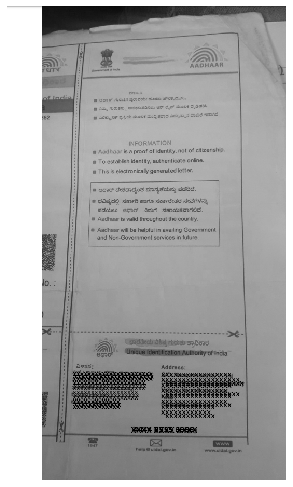

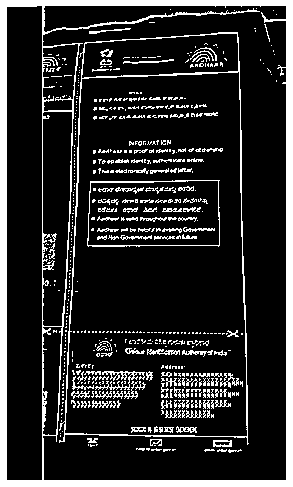

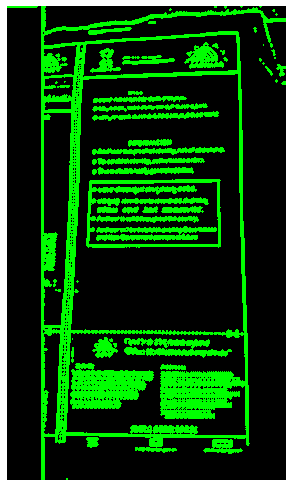

In [3]:
# https://cvisiondemy.com/extract-roi-from-image-with-python-and-opencv/
# https://cvisiondemy.com/license-plate-detection-with-opencv-and-python/

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hue, saturation, value = cv2.split(hsv)

# value = cv2.GaussianBlur(value, (5, 5), 0)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
topHat = cv2.morphologyEx(value, cv2.MORPH_TOPHAT, kernel)
blackHat = cv2.morphologyEx(value, cv2.MORPH_BLACKHAT, kernel)

# add and subtract between morphological operations
add = cv2.add(value, topHat)
subtract = cv2.subtract(add, blackHat)

# blur = cv2.GaussianBlur(subtract, (3, 3), 0)
blur = cv2.GaussianBlur(subtract, (5, 5), 0)
# blur = cv2.GaussianBlur(subtract, (7, 7), 0)
# blur = subtract.copy()

aadhaar_thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 19, 9)

display_image(value)
# display_image(topHat)
# display_image(blackHat)
display_image(aadhaar_thresh)

# All contours on threshold image
contours = cv2.findContours(aadhaar_thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
bruh = np.zeros_like(img)
cv2.drawContours(bruh, contours, -1, (0, 255, 0), 3)
display_image(bruh)

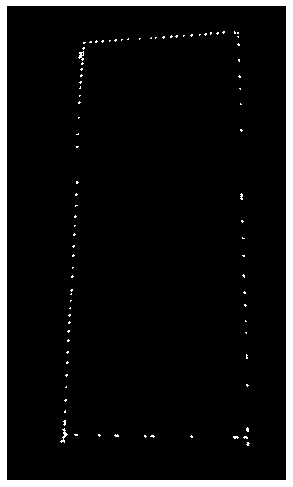

In [4]:
# Max Area Contour
bruh2 = np.zeros_like(img)
max_cnt = max(contours, key=cv2.contourArea)
cv2.drawContours(bruh2, max_cnt, -1, (255, 255, 255), 3)
display_image(bruh2)

Aadhar Contour


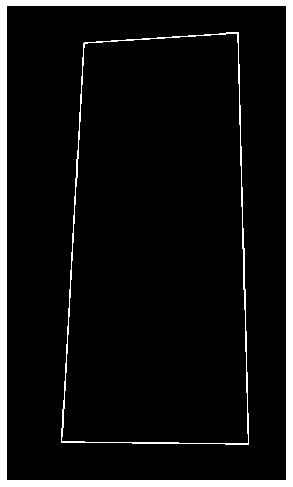

In [5]:
# Checking out all possible areas, just to be sure.
aadhaar = np.zeros_like(img)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
aadhaar_contour = None

# https://docs.opencv.org/4.1.2/dd/d49/tutorial_py_contour_features.html
for c in contours:
    # Contour Approximation 
    epsilon = 0.01 * cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, epsilon, True)

    if len(approx) == 4:
        aadhaar_contour = approx
        break
print("Aadhar Contour")
cv2.drawContours(aadhaar, [aadhaar_contour], -1, (255, 255, 255), 2)
display_image(aadhaar)

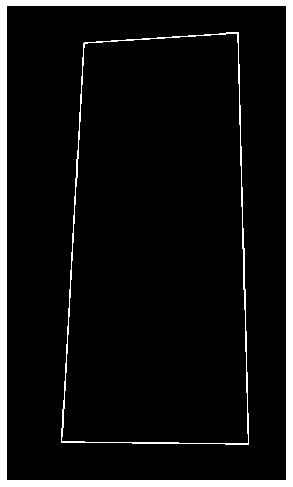

In [6]:
# Checking if max area apprach gives the same one or not
max_aadhaar = np.zeros_like(aadhaar)
# Contour Approximation 
max_cnt = cv2.approxPolyDP(max_cnt, 0.01 * cv2.arcLength(max_cnt, True), True)
if len(max_cnt) == 4:
    cv2.drawContours(max_aadhaar, [max_cnt], -1, (255, 255, 255), 2)
display_image(max_aadhaar)

In [7]:
aadhaar_contour

array([[[445,  51]],

       [[148,  71]],

       [[105, 839]],

       [[465, 843]]], dtype=int32)

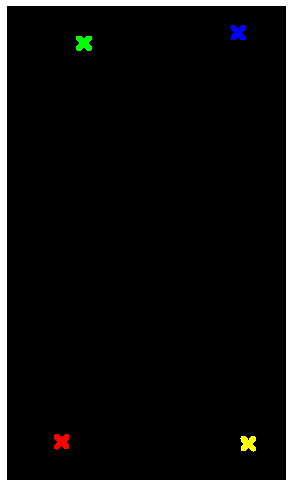

In [8]:
# Trying to find out the positions of obtained contour corners for proper warpPerspective alignment
test = np.zeros_like(img)
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255)]
for i, p in enumerate(aadhaar_contour):
    point = tuple(p[0])
    cv2.drawMarker(test, point, colors[i], cv2.MARKER_TILTED_CROSS, 20, 10)
# cv2.drawMarker(test, (0,51), (255, 255, 255), cv2.MARKER_TILTED_CROSS, 20, 10)
display_image(test)

_______

### warpPerspective transform - https://docs.opencv.org/4.1.2/da/d6e/tutorial_py_geometric_transformations.html

In [9]:
# aadhaar_corners = np.float32([blue, green, red, orange]) - color points from above
aadhaar_corners = np.float32([tuple(p[0]) for p in aadhaar_contour])
c, r = img.shape[:2]
# target/warped corners are set respectively to aadhaar_corners
warped_corners = np.float32([(r, 0), (0, 0), (0, c), (r, c)])

aadhaar_corners

array([[445.,  51.],
       [148.,  71.],
       [105., 839.],
       [465., 843.]], dtype=float32)

In [10]:
img.shape

(913, 538, 3)

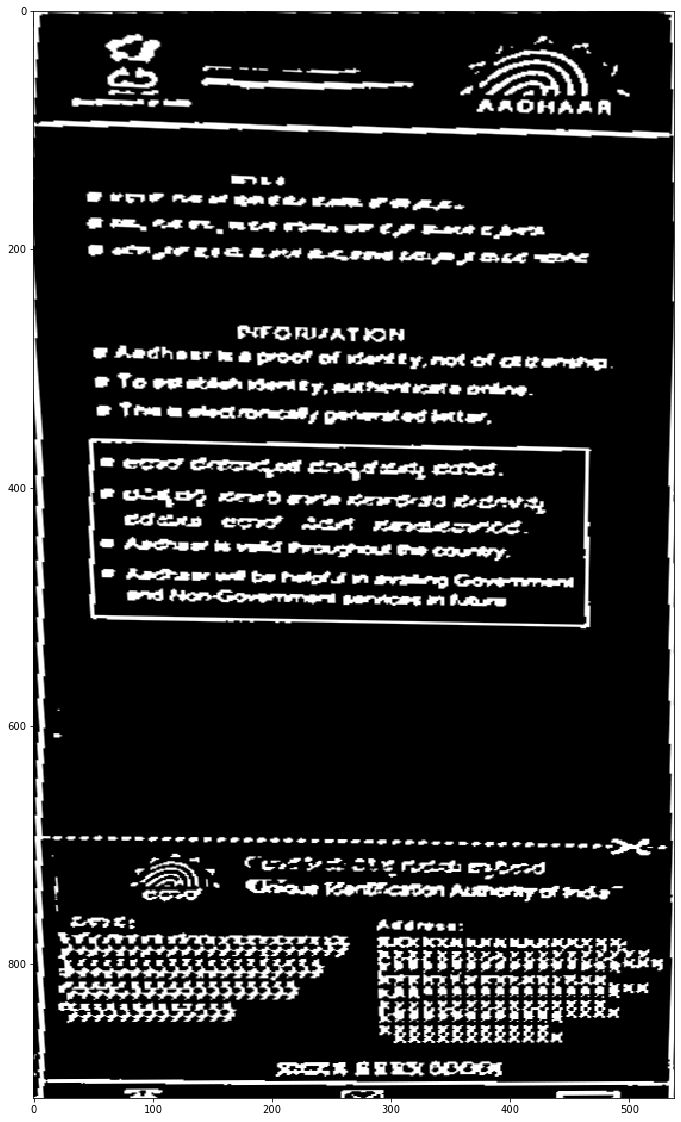

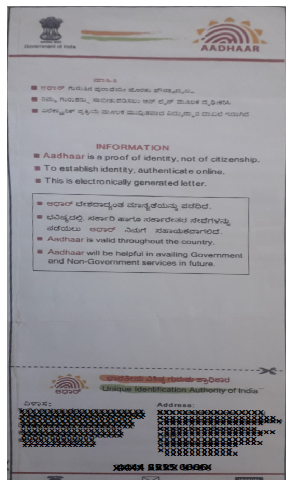

In [11]:
M = cv2.getPerspectiveTransform(aadhaar_corners, warped_corners)
warped_aadhaar_thresh = cv2.warpPerspective(aadhaar_thresh,M,(r,c))
warped_aadhaar = cv2.warpPerspective(img,M,(r,c))
display_image(warped_aadhaar_thresh, size=(20,20), axis=True)
display_image(warped_aadhaar)

__________

### Morphological Transforms -  https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html

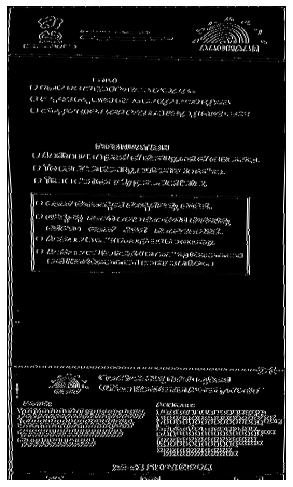

In [12]:
# Another reference - https://www.pyimagesearch.com/2015/11/30/detecting-machine-readable-zones-in-passport-images/
sobelX = cv2.Sobel(warped_aadhaar_thresh, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
sobelX = np.absolute(sobelX)
(minVal, maxVal) = (np.min(sobelX), np.max(sobelX))
sobelX = (255 * ((sobelX - minVal) / (maxVal - minVal))).astype("uint8")
display_image(sobelX)

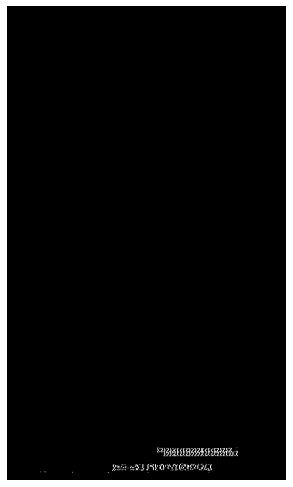

In [13]:
sobelX[:850, :] = 0
sobelX[900:, :] = 0
sobelX[:, :50] = 0
sobelX[:, -50:] = 0
display_image(sobelX)

In [14]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 5))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))
print(rectKernel)
print(sqKernel)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 

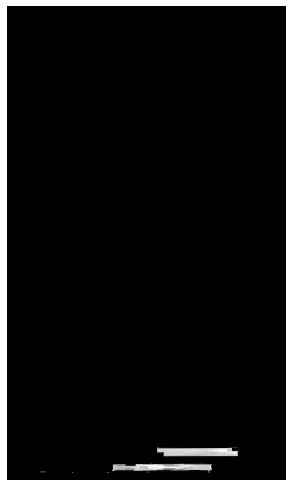

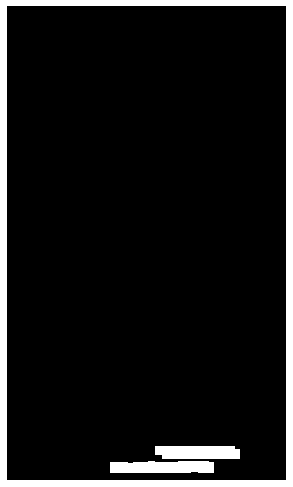

In [15]:
sobelX = cv2.morphologyEx(sobelX, cv2.MORPH_CLOSE, rectKernel)
display_image(sobelX)
final_thresh = cv2.threshold(sobelX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
final_thresh = cv2.morphologyEx(final_thresh, cv2.MORPH_OPEN, None, iterations=1)
final_thresh = cv2.dilate(final_thresh, None, iterations=5)
display_image(final_thresh)

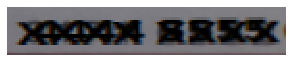

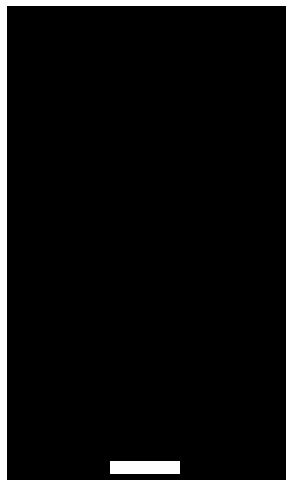

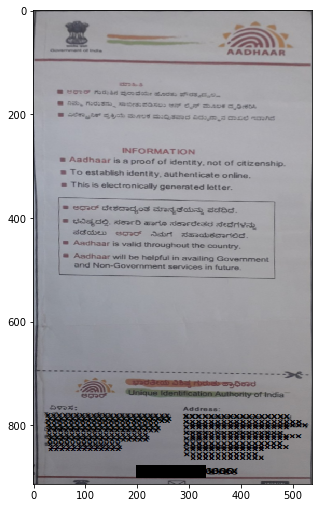

In [16]:
final_contour = cv2.findContours(final_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
final_contour = max(final_contour, key=cv2.contourArea)
redacted_warped_aadhaar = warped_aadhaar.copy()
redaction_mask = np.zeros_like(redacted_warped_aadhaar)

x, y, w, h = cv2.boundingRect(final_contour)
# Only 2/3'rd of the width is consider as ROI, as the last 4 digits are required to be visible
roi = warped_aadhaar[y:y + h, x:x + w*2//3].copy()
cv2.rectangle(redacted_warped_aadhaar, (x, y), (x + w*2//3, y + h), (0)**3, cv2.FILLED)
cv2.rectangle(redaction_mask, (x, y), (x + w*2//3, y + h), (255, 255, 255), cv2.FILLED)

display_image(roi)
display_image(redaction_mask)
display_image(redacted_warped_aadhaar, axis=True)

True

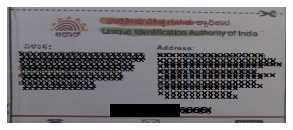

In [17]:
display_image(redacted_warped_aadhaar[690:,:])
cv2.imwrite('redacted_warped_aadhaar.png', redacted_warped_aadhaar[690:,:])

________

### Reversing the warpPerspective of redaction mask 
#### and redacting given original image

True

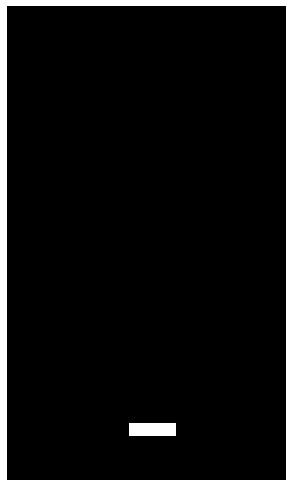

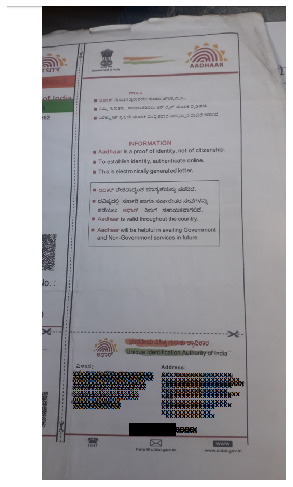

In [18]:
final_image = np.zeros_like(img)
cv2.warpPerspective(redaction_mask, M, (r,c), dst=final_image, flags=cv2.WARP_INVERSE_MAP)
display_image(final_image)

final_image = cv2.subtract(img, final_image)
display_image(final_image)

cv2.imwrite('final_redacted_aadhaar.png', final_image)